In [4]:
#this code introduces you to machine learning training and inference (predictions) in Python on AWS

#start a line with '!' to write to the command line instead. 
#This allows you to install packages to the EC2 instance from within jupyter
'''!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install numpy'''

#import the packages that you installed
import pandas as pd
import seaborn.apionly as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import randint as sp_randint
import time
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing, cross_validation
import pandas as pd

import pandas
df=pandas.read_csv('mfc.csv', error_bad_lines=False)
df.drop(['Urban','Specialty','State'], 1, inplace=True)
df.convert_objects(convert_numeric=True)
df.fillna(0, inplace=True)

#load a default seaborn dataset, display simple stats about data size, and then print the data's head

print 'shape of the data frame'+str(df.shape)
print df.groupby(['Gender']).size()
df.head(10)

shape of the data frame(25264, 8)
Gender
F     8647
M    16617
dtype: int64


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,Unnamed: 0,NPI,Gender,OpioidPrescriberRate,BrandClaimsPct,TotalOpioidCompanyPayments,Zip,ru2003
0,1,1518042571,M,2.34,0.108623,16.49,1001,2.0
1,2,1295852101,M,44.00,0.146667,0.00,47710,2.0
2,3,1376982371,M,9.32,0.000000,12.86,47710,2.0
3,4,1679731665,M,2.66,0.140436,0.00,47710,2.0
4,5,1568630127,M,9.28,0.086446,0.00,47710,2.0
5,6,1508869900,M,7.56,0.125402,0.00,47710,2.0
6,7,1184986523,M,7.25,0.248039,12.86,47710,2.0
7,8,1922447135,M,4.35,0.113712,12.86,47710,2.0
8,9,1912269903,M,4.79,0.000000,12.86,47710,2.0
9,10,1467485607,M,29.29,0.000000,0.00,47710,2.0


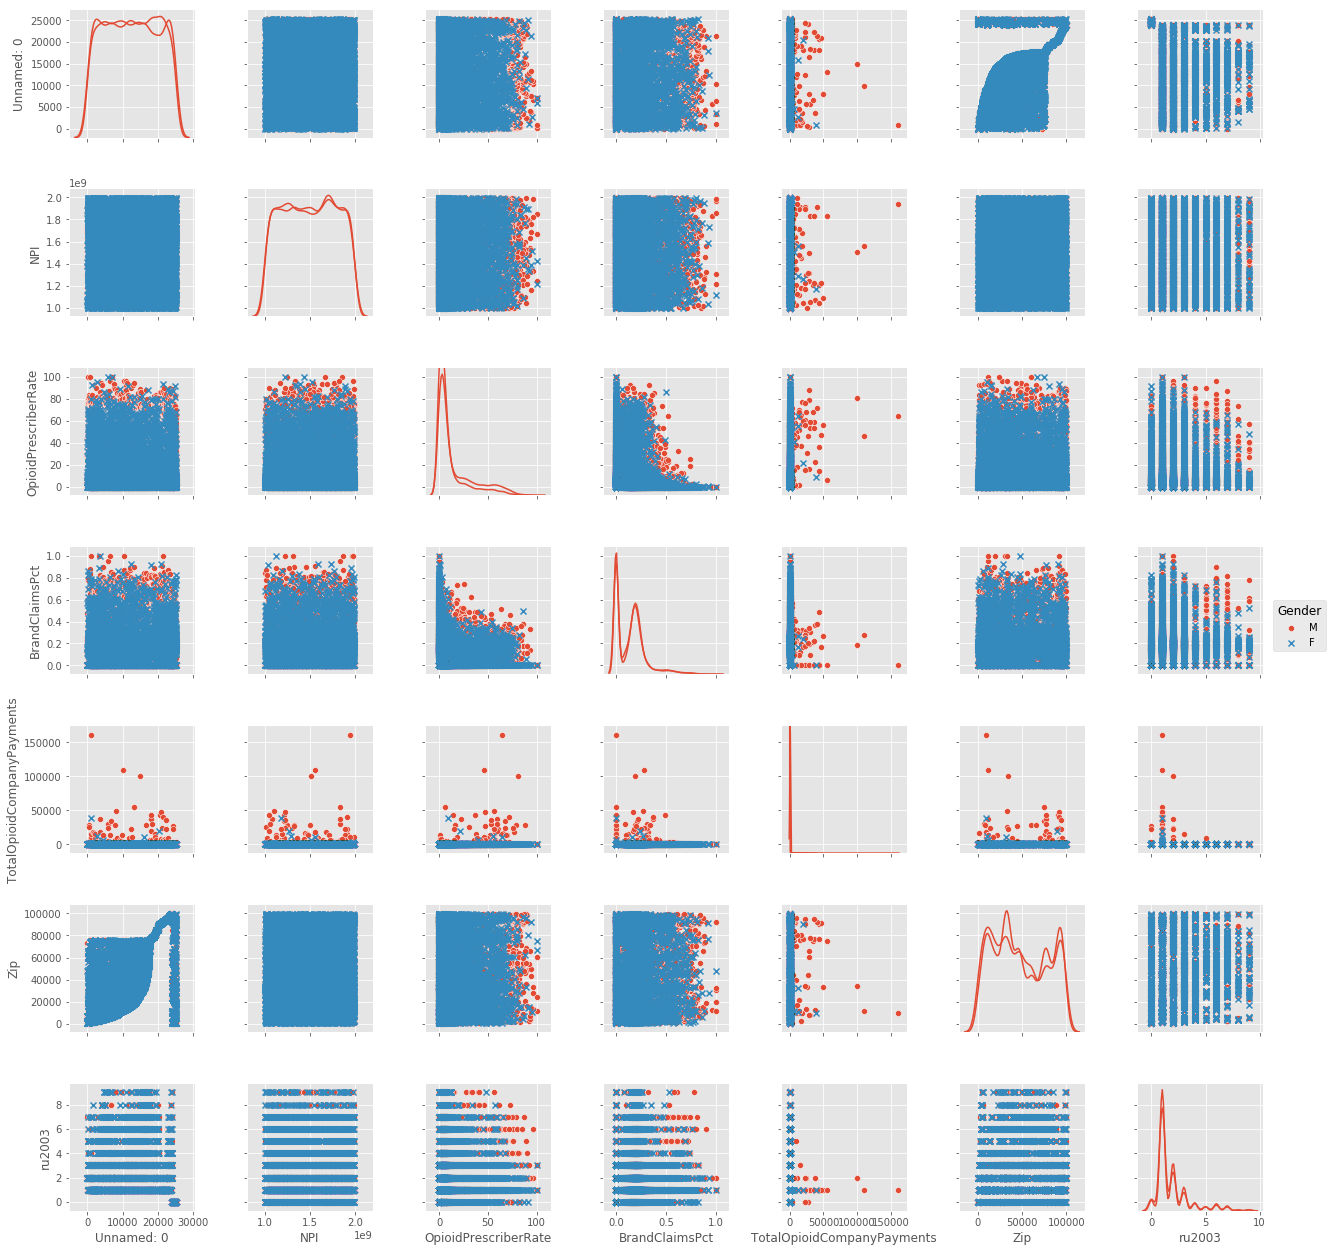

In [6]:
#showoff some of what seaborn can do
sns.pairplot(df, hue="Gender", diag_kind="kde",markers=['o','x'])

In [7]:
#let's group setosa and verginica together for the sake of this machine learning exercise
df['y']= np.where(df['Gender']=='M', 1,0)
print df.groupby(['y']).size()

y
0     8647
1    16617
dtype: int64


In [8]:
df.head(15)

,Unnamed: 0,NPI,Gender,OpioidPrescriberRate,BrandClaimsPct,TotalOpioidCompanyPayments,Zip,ru2003,y
0,1,1518042571,M,2.34,0.108623,16.49,1001,2.0,1
1,2,1295852101,M,44.00,0.146667,0.00,47710,2.0,1
2,3,1376982371,M,9.32,0.000000,12.86,47710,2.0,1
3,4,1679731665,M,2.66,0.140436,0.00,47710,2.0,1
4,5,1568630127,M,9.28,0.086446,0.00,47710,2.0,1
5,6,1508869900,M,7.56,0.125402,0.00,47710,2.0,1
6,7,1184986523,M,7.25,0.248039,12.86,47710,2.0,1
7,8,1922447135,M,4.35,0.113712,12.86,47710,2.0,1
8,9,1912269903,M,4.79,0.000000,12.86,47710,2.0,1
9,10,1467485607,M,29.29,0.000000,0.00,47710,2.0,1


In [9]:
#split into train and test
X=df.drop('Gender',1).drop('y',1)
y=df['y']
RANDOM_STATE=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print ('the number in training set: '+str(len(X_train)))
print ('the number in test set: '+str(len(X_test)))


the number in training set: 18948
the number in test set: 6316


In [10]:
#Randomized search for model selection
clf = DecisionTreeClassifier()
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean OOB score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"min_samples_split": sp_randint(1,20),
              "max_depth": [4, None],
              "min_samples_leaf": sp_randint(1,20),
                "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)
#this might take a minute to run
print("RandomizedSearchCV examined %d candidate parameter settings." % (n_iter_search))
report(random_search.cv_results_)



RandomizedSearchCV examined 10 candidate parameter settings.
Model with rank: 1
Mean OOB score: 0.655 (std: 0.001)
Parameters: {'min_samples_split': 17, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4}

Model with rank: 2
Mean OOB score: 0.654 (std: 0.003)
Parameters: {'min_samples_split': 9, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 19}

Model with rank: 2
Mean OOB score: 0.654 (std: 0.003)
Parameters: {'min_samples_split': 9, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 17}

Model with rank: 4
Mean OOB score: 0.654 (std: 0.003)
Parameters: {'min_samples_split': 5, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3}

Model with rank: 5
Mean OOB score: 0.653 (std: 0.003)
Parameters: {'min_samples_split': 12, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 8}

Model with rank: 6
Mean OOB score: 0.603 (std: 0.001)
Parameters: {'min_samples_split': 15, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 19}

Model with rank

In [11]:
#2.5 Train the decisiontreeclassifer according to the best paramater setting given above. Show model outputs.

#YOUR HOMEWORK IS TO SWITCH RANDOM FOREST CLASSIFIED WITH ANOTHER CLASSIFIER FROM THE SCIKIT LEARN API
#http://scikit-learn.org/stable/


clf = DecisionTreeClassifier(min_samples_split= 17, criterion= 'entropy', 
                             max_depth= 4, min_samples_leaf= 4)

clf = clf.fit(X_train, y_train)



    
y_pred=clf.predict(X_test)
y_scores=clf.predict_proba(X_test)
print ('\nconfusion matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores[:,1])
print('\nauc score '+str(auc(false_positive_rate, true_positive_rate)))




confusion matrix
Predicted     1   All
True                 
0          2138  2138
1          4178  4178
All        6316  6316

auc score 0.607970567017
